In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

import astropy.io.fits as pyfits
import astropy.wcs as wcs

import os

from sklearn.mixture import GaussianMixture

In [2]:
## import functions
import GMM_plot_library as pGMM
import GMM_functions as fGMM
import velocity_axis_datacube as vax

In [3]:
#### DESCRIPTION/NOTES ####

## Works for a 3D spectral datacube, clusters based on spectra (see Kabanovic+2020 for a description)

###############

## Input

In [4]:
## input for the data file
path_file = 'data/'
name_file = 'RCW79_CII_PCA_20_8_0p5_clean.fits'
unit_integrated_intensity = '$\int$T$_{mb}$dv (K km s$^{-1}$)'

## options plotting
save_spec_and_cluster_map = False
dpi_val = 300
path_plots = 'plots/'
save_name_spec_and_cluster_map = 'GMM_RCW79.pdf'

## input for the Gaussian Mixture Models
n_comps_min = 2
n_comps_max = 10
seed_val = 108
threshold = 0.001#1e-4
gmm_iter = 1000

## information for the observational information
noise_rms_obs = 0.6 ## K
min_velocity = -70. ## km/s
max_velocity = -25. ## km/s
unit_intensity = "T$_{mb}$ (K)"
unit_z_axis = "v (km s$^{-1}$)"

## Execute the script

In [5]:
## store data and header
hdu = pyfits.open(path_file + name_file)
hdu.info()
data = hdu[0].data
header = hdu[0].header

## store the spectral information
dv = 0.001*header['CDELT3']
crval = 0.001*header['CRVAL3']
crpix = header['CRPIX3']
print(dv)

## store the WCS information
header_c = header.copy()
header_c['NAXIS'] = 2
del header_c['NAXIS3']
del header_c['CTYPE3']
del header_c['CRVAL3']
del header_c['CDELT3']
del header_c['CRPIX3']
del header_c['CROTA3']

w = wcs.WCS(header_c)

Filename: data/RCW79_CII_PCA_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (188, 188, 160)   float32   
0.5


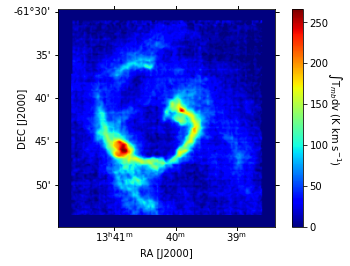

In [6]:
pGMM.inspect_intensity_map(data, dv, w, unit_integrated_intensity)

In [7]:
## reduce the data size along the z-axis to the region associated with emission
data_reduced = vax.reduce_z_axis_size(data, min_velocity, max_velocity, crval, dv, crpix)

## prepare the data before the GMM loop
index_array, data_resample = fGMM.prepare_data(data_reduced, min_velocity, max_velocity, crval, dv, crpix)

## loop over number of clusters for the GMM modeling
n_comps_list = []
bic_list = []
best_model = None
for i in range(n_comps_min,n_comps_max):
    print("Calculating GMM for " + str(i) + " number of components")
    n_comps_list.append(i)
    temp_model = fGMM.run_GMM(data_resample, i, seed_val, threshold, gmm_iter)
    temp_bic = temp_model.bic(data_resample)
    ## store the best fitting model
    if(i==n_comps_min):
        best_model = temp_model
    elif(temp_bic<np.nanmin(bic_list)):
        best_model = temp_model
    bic_list.append(temp_bic)

The minimal pixel along the z-axis is:40
The maximal pixel along the z-axis is:130
(90, 35344)
Dimensions of index_arr: (35344,)
[    0     1     2 ... 35341 35342 35343]
Dimensions of max_vals: (35344,)
[nan nan nan ... nan nan nan]
The maximum value is: 1.0
The minimum value is: -2.0776825
Calculating GMM for 2 number of components


/Users/lbonne/Documents/FEEDBACK/scriptsRCW79/GMM/GMM_functions.py:32: RuntimeWarning: All-NaN slice encountered
  max_vals = np.nanmax(data_resample,axis=0)


Calculating GMM for 3 number of components
Calculating GMM for 4 number of components
Calculating GMM for 5 number of components
Calculating GMM for 6 number of components
Calculating GMM for 7 number of components
Calculating GMM for 8 number of components
Calculating GMM for 9 number of components


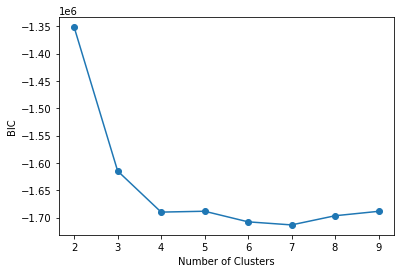

In [8]:
## plot BIC result as a function of the number of components
pGMM.plot_two_lists(n_comps_list,bic_list,"Number of Clusters","BIC")

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


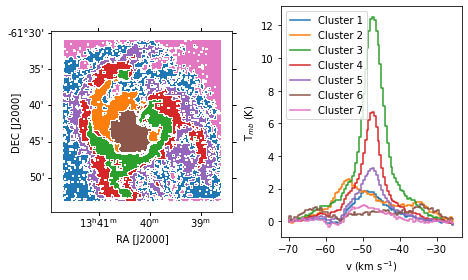

In [9]:
## Obtain the indices for the different clusters
cluster_inds = best_model.fit_predict(data_resample)

## Map the spatial distribution of the different clusters
len_x_orig_map = len(data[0][0])
len_y_orig_map = len(data[0])
cluster_map = fGMM.map_spatial_cluster_distribution(cluster_inds,index_array,len_x_orig_map,len_y_orig_map)

## Create the velocity array necessary for plotting
vel_arr = vax.create_velocity_array(min_velocity, max_velocity, crval, dv, crpix)

## Plot the spectra associated with each cluster and indicate the spatial distribution of the identified spectral clusters
pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, unit_z_axis, unit_intensity, w, save_spec_and_cluster_map, path_plots, save_name_spec_and_cluster_map, dpi_val)

